### Content Analysis
#### Joseph Denby

Load relevant packages and functions. 

In [1]:
import pandas as pd
import numpy as np
import random
import feather

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy
import lucem_illud

import nltk
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
%matplotlib inline

In [2]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)

In [3]:
def wordsample(tokens, n):
    '''
    takes a list of tokens and an amount of words and returns a random word sample
    
    Inputs:
        tokens - list of tokenized text
        n - int
    
    Outputs:
        sample - contiguous n-word sample from tokens
    '''
    
    if len(tokens) <= n:
        sample = tokens
    else:
        startindex = random.randint(1, len(tokens)-n)
        sample = tokens[startindex : startindex+n]
    
    return sample

In [4]:
def POSdict(tokens_POS):
    '''
    takes a list of tuples indicating POS taggings for tokenized words and returns 
    a dictionary counting up the POS tag instances
    
    Inputs:
        tokens_POS - list of tuples
        
    Outputs:
        POSdict - dictionary
    '''
    POSdict = {}
    for t in tokens_POS:
        word, tag = t
        if tag not in ['.', ',', "''", '#', '?', '!', ':', '(', ')', '$', '"', '``']:
            if tag not in POSdict:
                POSdict[tag] = 0
            POSdict[tag] += 1
    
    return POSdict

In [5]:
def getavgPOSdict(POSdictseries):
    '''
    takes a series of POSdicts and returns a dictionary with the average POS counts 
    
    Inputs:
        POSdictseries - series of POSdicts
        
    Outputs:
        avgPOSdict - dictionary
    '''
    
    avgPOSdict = {}
    total = len(POSdictseries)
    
    for d in POSdictseries:
        for k, v in d.items():
            if k not in avgPOSdict:
                avgPOSdict[k] = 0
            avgPOSdict[k] += v/total
    
    return avgPOSdict
    

In [6]:
def averageSampleCounts(dataframe, n):
    '''
    Takes a DataFrame and returns a dictionary
    with the counts for each POS found in a random contiguous n word sample.
    
    Inputs:
        dataframe - DataFrame
    
    Outputs:
        avgPOSdict - dictionary 
    
    '''
    tag = str(n) + 'wordsample'
    
    dataframe[tag] = dataframe['tokens'].apply(lambda x: wordsample(x, n))
    dataframe['tokens_POS'] = [nltk.pos_tag(t) for t in dataframe[tag]]
    
    dataframe['POSdict'] = dataframe['tokens_POS'].apply(lambda x: POSdict(x))
    avgPOSdict = getavgPOSdict(dataframe['POSdict'])
    
    return avgPOSdict
    
    

In [7]:
def getPOSdf(chatavgavgPOSdict, bookavgavgPOSdict):
    '''
    Takes two dictionaries with the average average POS counts and converts them into a single melted DataFrame,
    primed for plotting.
    
    Inputs:
        chatavgavgPOSdict - dictionary
        bookavgavgPOSdict - dictionary
    Output:
        compareavgPOSdf - DataFrame
    '''
    
    chatavgPOSdf = pd.DataFrame.from_dict(chatavgavgPOSdict, orient = 'index')
    bookavgPOSdf = pd.DataFrame.from_dict(bookavgavgPOSdict, orient = 'index')
    
    chatavgPOSdf = chatavgPOSdf.reset_index()
    bookavgPOSdf = bookavgPOSdf.reset_index()
    
    chatavgPOSdf = chatavgPOSdf.rename(columns = {'index': 'POS', 0: 'chat'})
    bookavgPOSdf = bookavgPOSdf.rename(columns = {'index': 'POS', 0: 'book'})
    
    compareavgPOSdf = bookavgPOSdf.merge(chatavgPOSdf, how='left', on='POS',)
    compareavgPOSdf['abs_diff'] = compareavgPOSdf.apply(lambda x: x['book'] - x['chat'], axis=1)
    compareavgPOSdf = compareavgPOSdf.sort_values('abs_diff', ascending=False)
    compareavgPOSdf = compareavgPOSdf.reset_index(drop=True)
    compareavgPOSdf = compareavgPOSdf.melt(id_vars=['POS'], value_vars=['book', 'chat'], var_name='source', value_name='avgcount')
    
    return compareavgPOSdf

In [8]:
def getPOSsterrs(avgPOSdicts):
    POSsterrs = {}
    for d in avgPOSdicts:
        for k, v in d.items():
            if k not in POSsterrs:
                POSsterrs[k] = []
            POSsterrs[k].append(v)
                    
    for k, v in POSsterrs.items():
        POSsterrs[k] = np.array(v)
        POSsterrs[k] = np.std(v)/np.sqrt(len(POSsterrs[k]))
    return POSsterrs

In [ ]:
def makePOScountsdf(POSdicts):
    '''
    Takes list/series of POS dictionaries and creates a dataframe with the counts for each POS tag.
    '''
    POSdicts = POSdicts.tolist()
    firstdic = POSdicts.pop()
    POScountsdf = pd.DataFrame.from_dict(firstdic,orient='index')
    
    for d in POSdicts:
        initdf = pd.DataFrame.from_dict(d,orient='index')
        POScountsdf = POScountsdf.merge(initdf, how='left', left_index=True, right_index=True)
    
    return POScountsdf

In [64]:
def avgwordsample(tokens, wordn, samplen):
    '''
    Takes a list of tokens and returns an dictionary of POS counts for a wordn random sample conducted samplen times.
    
    Outputs:
        avgPOSdict 
    '''
    tag = 'avg' + str(samplen) + 'word sample'
    sampledictlist = []
    
    for _ in range(samplen):
        sample = wordsample(tokens, wordn)
        samplePOS = nltk.pos_tag(sample)
        sampledict = POSdict(samplePOS)
        sampledictlist.append(sampledict)
    
    avgPOSdict = getavgPOSdict(sampledictlist)
    
    return avgPOSdict

TODO
- Organize by difference between counts. __[DONE]__
- Look at change over time (based on session or suggested grade/age level for books) __[DONE]__
- look at distribution of kids (variability, not just means) and plot alongside books
- Try parsing - look at tree depth over book sentences. (*some measure of complexity*)
- kids POS productions over time
- compare with adult conversation corpus (Santa Barbara?) and adult book text
- Lexile measure?
- Examine differences in trajectory for chat by SES
- Investigate word specificity / concreteness with WordNet
- Oxford Children's Corpus (look at writing *by* children)

Read in dataframes:

LDP CHAT DATAFRAME

In [9]:
ldpdf = pd.read_csv('ldpdf.csv', index_col=0)

In [10]:
ldpdf['tokens'] = ldpdf.p_chat.apply(lambda x: nltk.wordpunct_tokenize(x))
ldpdf['word_count'] = ldpdf.tokens.apply(lambda x: len(x))

In [11]:
#set word sample size
n = 150

In [185]:
ldpdf.head()

,subject,session,p_chat,chat_tokens,tokens,word_count,150wordsample,tokens_POS,POSdict,avg150wordPOScount
0,22,1,"play with Mommy's hand .no .no, no, no .nope n...","['play', 'with', 'Mommy', ""'"", 's', 'hand', '....","[play, with, Mommy, ', s, hand, ., no, ., no, ...",4654,"[?, hmmm, ., yeah, ., you, say, +..., shh, ., ...","[(teach, VB), (her, PRP), (that, IN), (!, .), ...","{'VB': 15, 'PRP': 9, 'IN': 11, 'RP': 8, 'CC': ...","{'PRP': 12.580000000000002, 'JJ': 6.6399999999..."
1,22,2,what are you crawling for ?stand up .what are ...,"['what', 'are', 'you', 'crawling', 'for', '?',...","[what, are, you, crawling, for, ?, stand, up, ...",5746,"[., and, who, ', s, that, ?, baba, ,, right, !...","[(boom, NN), (!, .), (right, NN), (., .), (tha...","{'NN': 38, 'IN': 5, 'JJ': 8, 'NNP': 5, 'POS': ...","{'VB': 11.94, 'DT': 7.719999999999999, 'RB': 5..."
2,22,3,you want to show her how you do a head+stand ?...,"['you', 'want', 'to', 'show', 'her', 'how', 'y...","[you, want, to, show, her, how, you, do, a, he...",5445,"[bus, ?, hence, the, song, ., right, ., there,...","[(?, .), (you, PRP), (too, RB), (write, VB), (...","{'PRP': 11, 'RB': 9, 'VB': 17, 'JJ': 7, 'VBP':...","{'NN': 17.520000000000003, 'IN': 7.27999999999..."
3,22,4,how do flowers taste ?yeah .do you eat flowers...,"['how', 'do', 'flowers', 'taste', '?', 'yeah',...","[how, do, flowers, taste, ?, yeah, ., do, you,...",8277,"[?, this, was, Zevy, ', s, book, when, he, was...","[(big, JJ), (furry, NN), (+..., VBD), (two, CD...","{'JJ': 10, 'NN': 43, 'VBD': 2, 'CD': 1, 'RB': ...","{'NN': 19.820000000000007, 'NNP': 3.9600000000..."
4,22,5,what ?you brought it down because you said you...,"['what', '?', 'you', 'brought', 'it', 'down', ...","[what, ?, you, brought, it, down, because, you...",6862,"[., yeah, ,, a, talking, one, ., yeah, ,, but,...","[(who, WP), (are, VBP), (they, PRP), (having, ...","{'WP': 5, 'VBP': 5, 'PRP': 16, 'VBG': 2, 'DT':...","{'NN': 19.48, 'IN': 8.759999999999996, 'CC': 1..."


In [80]:
ldpdf['avg150wordPOScount'] = ldpdf['tokens'].apply(lambda x:avgwordsample(x, 150, 50))

In [102]:
sessionPOSdicts = ldpdf.groupby('session').avg150wordPOScount.apply(list)

In [106]:
sessionPOSdicts = sessionPOSdicts.to_frame()

In [110]:
sessionPOSdicts.head()

,avg150wordPOScount,avgPOS
session,,
1,"[{'PRP': 12.580000000000002, 'JJ': 6.639999999...","{'PRP': 13.156103896103895, 'JJ': 7.4335064935..."
2,"[{'VB': 11.94, 'DT': 7.719999999999999, 'RB': ...","{'VB': 11.0435, 'DT': 8.697750000000003, 'RB':..."
3,"[{'NN': 17.520000000000003, 'IN': 7.2799999999...","{'NN': 20.47476190476191, 'IN': 7.311666666666..."
4,"[{'NN': 19.820000000000007, 'NNP': 3.960000000...","{'NN': 19.44666666666667, 'NNP': 5.36952380952..."
5,"[{'NN': 19.48, 'IN': 8.759999999999996, 'CC': ...","{'NN': 19.079767441860454, 'IN': 7.89348837209..."


In [109]:
sessionPOSdicts['avgPOS'] = sessionPOSdicts['avg150wordPOScount'].apply(lambda x: getavgPOSdict(x))

Creates DataFrame and plots with POS counts for each 150 word sample taken from each session.

In [179]:
sessioncountsdf = pd.DataFrame()
for i, r in sessionPOSdicts.iterrows():
    for d in r['avg150wordPOScount']:
        sessiondf = pd.DataFrame.from_dict(d, orient = 'index')
        sessiondf['session'] = i
        sessioncountsdf = sessioncountsdf.append(sessiondf)
sessioncountsdf.reset_index(inplace = True)
sessioncountsdf = sessioncountsdf.rename(columns = {'index':'POS', 0:'count'})

In [233]:
sessioncountsdf.tail()

,POS,count,session
26672,JJR,0.50,12
26673,NNPS,0.12,12
26674,JJS,0.02,12
26675,FW,0.02,12
26676,NN,1.00,12


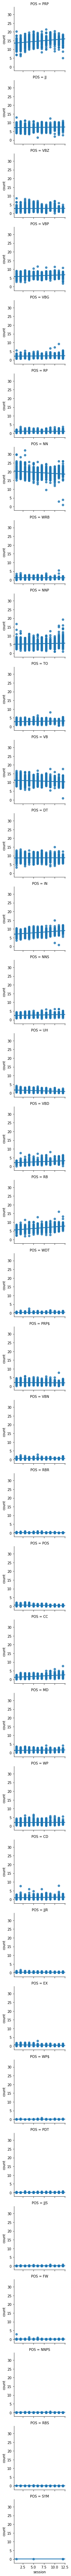

In [193]:
g = sns.FacetGrid(sessioncountsdf, row = 'POS')
g.map(sns.regplot, "session", "count")

Creates DataFrame and plots with the average POS counts for 150 word samples by each session.

In [228]:
sessionavgcountsdf = pd.DataFrame()
for i, r in sessionPOSdicts.iterrows():
    sessiondf = pd.DataFrame.from_dict(r['avgPOS'], orient = 'index')
    sessiondf.reset_index(inplace=True)
    sessiondf['session'] = i
    sessionavgcountsdf = sessionavgcountsdf.append(sessiondf)
    sessionavgcountsdf.reset_index(inplace =True, drop=True)

sessionavgcountsdf = sessionavgcountsdf.rename(columns = {'index':'POS', 0:'count'})


    
    

In [229]:
sessionavgcountsdf.head()

,POS,count,session
0,PRP,13.156104,1
1,JJ,7.433506,1
2,VBZ,2.435325,1
3,VBP,5.691429,1
4,VBG,2.257662,1


In [230]:
bookavgavgPOSdict = getavgPOSdict(bookavgPOSdicts)

In [234]:
bookavgavgPOSdf = pd.DataFrame.from_dict(bookavgavgPOSdict, orient = 'index')
bookavgavgPOSdf.reset_index(inplace=True)
bookavgavgPOSdf['session'] = 13 #stipulate books as their own session
bookavgavgPOSdf['book'] = True
bookavgavgPOSdf = bookavgavgPOSdf.rename(columns = {'index':'POS', 0:'count'})
sessionavgcountsdf['book'] = False
booksessionavgcountsdf = sessionavgcountsdf.append(bookavgavgPOSdf)


In [236]:
booksessionavgcountsdf.head()

,POS,count,session,book
0,PRP,13.156104,1,False
1,JJ,7.433506,1,False
2,VBZ,2.435325,1,False
3,VBP,5.691429,1,False
4,VBG,2.257662,1,False


In [243]:
booksessionavgcountsdf.to_csv('avgPOScounts.csv')

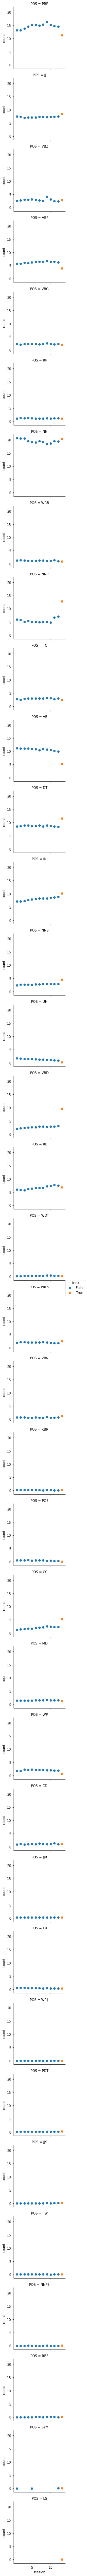

In [241]:
g = sns.FacetGrid(booksessionavgcountsdf, row = 'POS', hue='book')
g = g.map(plt.scatter, 'session', 'count')
g.add_legend()

In [22]:
chatavgPOSdicts = []
for i in range(100):
    if i % 10 == 0:
        print(i)
    dikt = averageSampleCounts(ldpdf, n)
    chatavgPOSdicts.append(dikt)

#chatavgavgPOSdict = getavgPOSdict(chatavgPOSdicts)

0


KeyboardInterrupt: 

In [152]:
chatPOSsterrs = {}
for d in chatavgPOSdicts:
    for k, v in d.items():
        if k not in chatPOSsterrs:
            chatPOSsterrs[k] = []
        chatPOSsterrs[k].append(v)
for k, v in chatPOSsterrs.items():
    chatPOSsterrs[k] = np.array(v)
    chatPOSsterrs[k] = np.std(v)/np.sqrt(len(chatPOSsterrs[k]))

In [158]:
chatPOSsterrs = getPOSsterrs(chatavgPOSdicts)

In [123]:
chatavgavgPOSdict = getavgPOSdict(chatavgPOSdicts)

BOOK DATAFRAME

In [14]:
bookdf = pd.read_csv("bookdf.csv", index_col=0)

## 
bookdf = bookdf.drop(15) #to get rid of 'Goodnight Moon' which has less than 100 words
bookdf = bookdf.reset_index(drop=True)
##

bookdf['tokens'] = bookdf['text'].apply(lambda x: nltk.wordpunct_tokenize(x))
#bookdf['nltktext'] = bookdf['tokens'].apply(lambda x: nltk.Text(x))
bookdf['word_count'] = bookdf.tokens.apply(lambda x: len(x))
#bookdf['wordsample100'] = bookdf.tokens.apply(lambda x: wordsample100(x))

In [196]:
bookdf.head()

,author,text,title,tokens,word_count,150wordsample,tokens_POS,POSdict,avg150wordPOScount
0,Jules Feiffer,"George’s mother said: ""Bark, George."" George w...","Bark, George","[George, ’, s, mother, said, :, "", Bark, ,, Ge...",364,"[George, ."", George, went, :, "", Quack, -, qua...","[(George, NNP), (."", NNP), (George, NNP), (wen...","{'NNP': 44, 'VBD': 12, 'NN': 23, 'VBZ': 5, 'VB...","{'VBD': 12.599999999999998, 'NN': 19.880000000..."
1,Robert McCloskey,"One day, Little Sal went with her mother to Bl...",Blueberries for Sal,"[One, day, ,, Little, Sal, went, with, her, mo...",1253,"[and, thinking, about, storing, up, food, for,...","[(and, CC), (thinking, VBG), (about, IN), (sto...","{'CC': 10, 'VBG': 5, 'IN': 12, 'RP': 3, 'NN': ...","{'NN': 16.240000000000002, 'IN': 11.2800000000..."
2,Bill Martin Jr,"Brown Bear, Brown Bear, What do you see? I see...","Brown Bear, Brown Bear, What Do You See?","[Brown, Bear, ,, Brown, Bear, ,, What, do, you...",251,"[looking, at, me, ., Yellow, Duck, ,, Yellow, ...","[(looking, VBG), (at, IN), (me, PRP), (., .), ...","{'VBG': 8, 'IN': 8, 'PRP': 24, 'JJ': 8, 'NNP':...","{'JJ': 9.100000000000001, 'NNP': 22.9000000000..."
3,Doreen Cronin,Farmer Brown has a problem. His cows like to t...,"Click, Clack, Moo Cows that Type","[Farmer, Brown, has, a, problem, ., His, cows,...",541,"[Then, ,, he, couldn, ’, t, believe, his, eyes...","[(Then, RB), (,, ,), (he, PRP), (couldn, VBZ),...","{'RB': 6, 'PRP': 7, 'VBZ': 4, 'JJ': 10, 'NN': ...","{'NNP': 17.020000000000007, 'DT': 17.740000000..."
4,Judi Barrett,We were all sitting around the big kitchen tab...,Cloudy With a Chance of Meatballs,"[We, were, all, sitting, around, the, big, kit...",1423,"[and, hard, rolls, ,, some, with, seeds, and, ...","[(and, CC), (hard, JJ), (rolls, NNS), (,, ,), ...","{'CC': 11, 'JJ': 7, 'NNS': 12, 'DT': 16, 'IN':...","{'DT': 15.26, 'JJ': 8.36, 'NN': 23.06000000000..."


In [195]:
bookdf['avg150wordPOScount'] = bookdf['tokens'].apply(lambda x:avgwordsample(x, 150, 50))

Creates DataFrame and plot of POS counts for each book's average 150 word sample.

In [199]:
bookcountsdf = pd.DataFrame()
for i, r in bookdf.iterrows():
    bookPOSdf = pd.DataFrame.from_dict(r['avg150wordPOScount'], orient = 'index')
    bookPOSdf.reset_index(inplace=True)
    bookcountsdf = bookPOSdf.append(bookcountsdf)
    bookcountsdf.reset_index(inplace =True, drop=True)

bookcountsdf = bookcountsdf.rename(columns = {'index':'POS', 0:'count'})
    
    

In [201]:
bookcountsdf.head()

,POS,count
0,NNS,16.88
1,VBP,4.04
2,IN,14.14
3,DT,17.10
4,NN,24.22


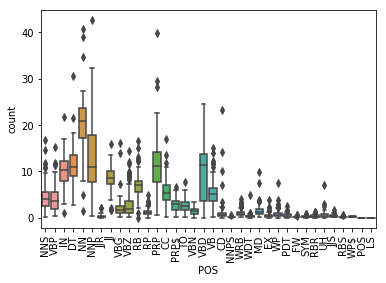

In [211]:
g = sns.boxplot(x = 'POS', y='count', data=bookcountsdf)
#axes = g.axes.flatten()
g = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [16]:
bookavgPOSdicts = []
for i in range(100):
    if i % 10 == 0:
        print (i)
    dikt = averageSampleCounts(bookdf, n)
    bookavgPOSdicts.append(dikt)

#bookavgavgPOSdict = getavgPOSdict(bookavgPOSdicts)

0
10
20
30
40
50
60
70
80
90


In [214]:
bookavgavgPOSdict = getavgPOSdict(bookavgPOSdicts)

In [215]:
bookavgavgPOSdict

{'CC': 5.297070707070706,
 'CD': 1.1004040404040398,
 'DT': 11.504343434343431,
 'EX': 0.3575757575757582,
 'FW': 0.039696969696969696,
 'IN': 10.11444444444444,
 'JJ': 8.536262626262623,
 'JJR': 0.2189898989898989,
 'JJS': 0.19898989898989902,
 'LS': 0.00010101010101010102,
 'MD': 1.3168686868686874,
 'NN': 20.384949494949495,
 'NNP': 12.79050505050505,
 'NNPS': 0.038181818181818206,
 'NNS': 4.47030303030303,
 'PDT': 0.26909090909090894,
 'POS': 0.0014141414141414144,
 'PRP': 11.239595959595965,
 'PRP$': 2.631414141414141,
 'RB': 6.878989898989896,
 'RBR': 0.17181818181818204,
 'RBS': 0.029595959595959603,
 'RP': 1.0165656565656562,
 'SYM': 0.06242424242424243,
 'TO': 2.5013131313131303,
 'UH': 0.27373737373737356,
 'VB': 5.2873737373737395,
 'VBD': 9.564747474747476,
 'VBG': 1.9670707070707056,
 'VBN': 1.1406060606060602,
 'VBP': 3.9887878787878774,
 'VBZ': 2.8071717171717148,
 'WDT': 0.22696969696969707,
 'WP': 0.6660606060606058,
 'WP$': 0.007676767676767677,
 'WRB': 0.896363636363

In [31]:
bookPOScountdf = pd.DataFrame.from_dict(bookavgPOSdicts[0],orient='index')

In [39]:
firstdic = bookdf.POSdict.tolist().pop()

In [40]:
firstdic

{'CC': 7,
 'DT': 13,
 'IN': 15,
 'JJ': 6,
 'NN': 27,
 'NNP': 7,
 'NNS': 20,
 'PRP': 2,
 'PRP$': 3,
 'RB': 2,
 'RP': 2,
 'TO': 4,
 'VB': 1,
 'VBD': 2,
 'VBG': 2,
 'VBN': 3,
 'VBP': 5,
 'VBZ': 3}

In [42]:
bookPOScountsdf = makePOScountsdf(bookdf.POSdict)

In [213]:
compareavgPOSdf = getPOSdf(chatavgavgPOSdict, bookavgavgPOSdict)

NameError: name 'chatavgavgPOSdict' is not defined

In [212]:
compareavgPOSdf

NameError: name 'compareavgPOSdf' is not defined

The following plot shows the average POS counts for word samples from both corpora.

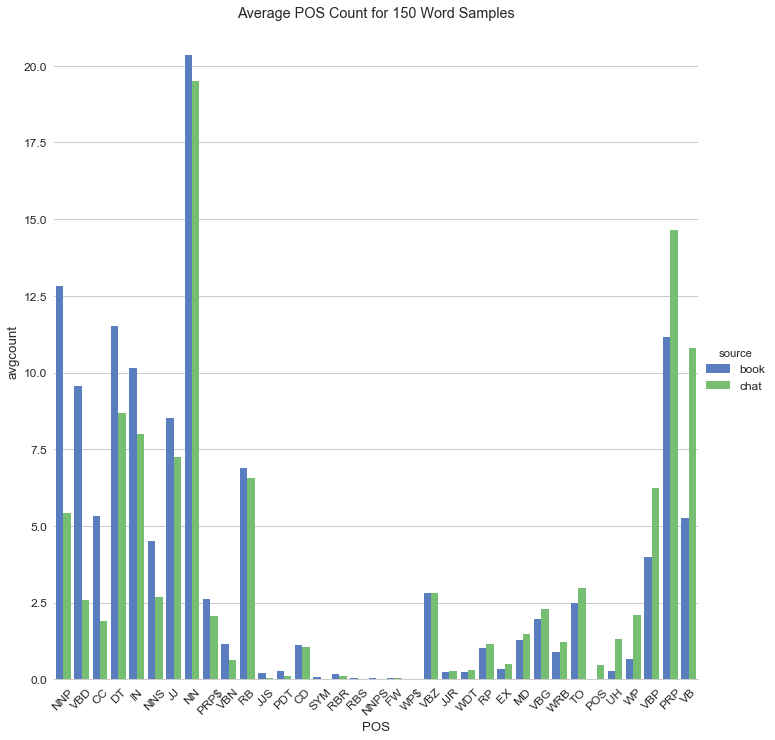

In [200]:
sns.set(font_scale=1.2, style='whitegrid')

g = sns.factorplot(x = 'POS', y = 'avgcount', hue='source', data=compareavgPOSdf, size=10, kind='bar', palette='muted')
g.despine(left = True)
g.set_xticklabels(rotation=45)
axes = g.axes.flatten()
axes[0].set_title('Average POS Count for ' + str(n) + ' Word Samples')

g.savefig('avgPOS150.pdf')

`NNP` = Proper Noun; `VBP` = Verb 'to be', singular present non 3rd (e.g, 'am', 'are'); `DT` = Determiner (e.g., 'a', 'the', 'every'); `VBD` = Verb 'to be', past tense; `IN`= preposition, subordinating conjunction; `CC` = coordination conjunction (e.g., 'and'); `PRP` = Personal Pronoun (e.g., 'I', 'she', 'you', 'it'); `VB` = verb 'to be', base form (i.e., 'be'); `NNS` = plural nouns; `WP` = verb, sing. present non 3rd (e.g., 'take', 'play')

Compute stopword list based on corpus frequency and create tokenized and normalized nltk sentence columns.

In [5]:
alltokens = bookdf['tokens'].sum()

#all words sorted by frequency
allcountedWords = wordCounter(alltokens)
allcountedWords.sort_values('count', ascending=False, inplace=True)

stop_words_freq = []
countsDict = {}
for word in alltokens:
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:100]
for word, count in word_counts:
    if word == 'little':
        break
    else:
        stop_words_freq.append(word)

In [7]:
bookdf['tokenized_sents'] = bookdf['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
bookdf['normalized_sents'] = bookdf['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = stop_words_freq, stemmer = None) for s in x])
bookdf[:5]

,author,text,title,tokens,nltktext,tokenized_sents,normalized_sents
0,Jules Feiffer,"George’s mother said: ""Bark, George."" George w...","Bark, George","[George, ’, s, mother, said, :, ``, Bark, ,, G...","(George, ’, s, mother, said, :, ``, Bark, ,, G...","[[George, ’, s, mother, said, :, ``, Bark, ,, ...","[[george, mother, bark, george], [george, went..."
1,Robert McCloskey,"One day, Little Sal went with her mother to Bl...",Blueberries for Sal,"[One, day, ,, Little, Sal, went, with, her, mo...","(One, day, ,, Little, Sal, went, with, her, mo...","[[One, day, ,, Little, Sal, went, with, her, m...","[[one, day, little, sal, went, mother, blueber..."
2,Bill Martin Jr,"Brown Bear, Brown Bear, What do you see? I see...","Brown Bear, Brown Bear, What Do You See?","[Brown, Bear, ,, Brown, Bear, ,, What, do, you...","(Brown, Bear, ,, Brown, Bear, ,, What, do, you...","[[Brown, Bear, ,, Brown, Bear, ,, What, do, yo...","[[brown, bear, brown, bear, what, do, see], [i..."
3,Doreen Cronin,Farmer Brown has a problem. His cows like to t...,"Click, Clack, Moo Cows that Type","[Farmer, Brown, has, a, problem, ., His, cows,...","(Farmer, Brown, has, a, problem, ., His, cows,...","[[Farmer, Brown, has, a, problem, .], [His, co...","[[farmer, brown, has, problem], [cows, type], ..."
4,Judi Barrett,We were all sitting around the big kitchen tab...,Cloudy With a Chance of Meatballs,"[We, were, all, sitting, around, the, big, kit...","(We, were, all, sitting, around, the, big, kit...","[[We, were, all, sitting, around, the, big, ki...","[[we, were, sitting, around, big, kitchen, tab..."


Now, create a tf-idf matrix. This is a sparse matrix with each row being a document (book) and each column a word appearing in the corpus.

First, a vectorizer that creates a count matrix (each field is the number of times a word appears in a document).

In [117]:
#First it needs to be initialized
bookCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
bookgroupVects = bookCountVectorizer.fit_transform(bookdf['text'])

In [16]:
bookgroupVects.shape

(100, 5577)

In [49]:
bookCountVectorizer.vocabulary_.get("")

Now, compute the tf-idf matrix. This assigns a score (tf-idf) to each word in each document according to its 'tellingness.' Each score is an indication of the word's importance within a document weighted by its relative presence across the entire corpus.

In [57]:

#initialize
bookTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stop_words_freq, norm='l2')
#train
bookgroupTFVects = bookTFVectorizer.fit_transform(bookdf['text'])

In [62]:
list(zip(bookTFVectorizer.vocabulary_.keys(), bookgroupTFVects.data))[:20]

[('george', 0.8250452029628907),
 ('mother', 0.0806859374239559),
 ('bark', 0.30346153103359197),
 ('went', 0.10025854047243683),
 ('meow', 0.07409044053577216),
 ('no', 0.02782304744964275),
 ('cats', 0.023572720084654025),
 ('go', 0.053296564657065615),
 ('dogs', 0.06539709675813102),
 ('arf', 0.12138461241343679),
 ('now', 0.02875583332681148),
 ('quack', 0.1481808810715443),
 ('ducks', 0.02607259267803477),
 ('oink', 0.07821777803410432),
 ('pigs', 0.02607259267803477),
 ('moo', 0.055692561019956906),
 ('took', 0.013447656237325984),
 ('vet', 0.2124230717235144),
 ('ll', 0.011014437746450794),
 ('soon', 0.014532100367612747)]

In [123]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 4).fit(bookgroupTFVects.toarray())
reduced_data = pca.transform(bookgroupTFVects.toarray())
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
booktitles = bookdf['title']
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [122]:
redu

array([[-6.92441597e-04, -3.10051955e-04, -1.73959139e-03, ...,
        -3.74375126e-04, -1.84840795e-03, -8.40431720e-05],
       [ 6.11263516e-04,  1.76518196e-04, -5.11822857e-04, ...,
        -5.01952367e-04,  3.72336919e-03, -1.87272269e-04]])

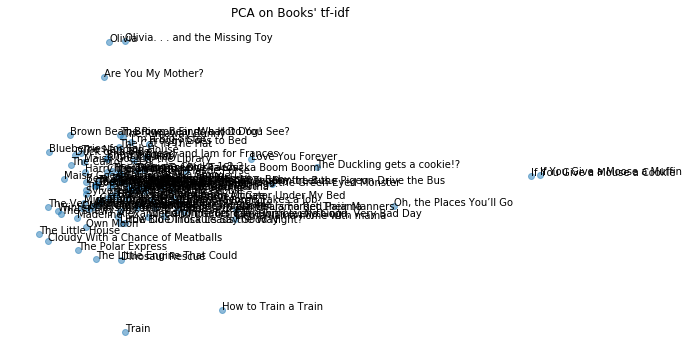

In [127]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 2], reduced_data[:, 3], alpha = 0.5)
for i, booktitle in enumerate(booktitles):
    ax.annotate(booktitle, (reduced_data[i,2], reduced_data[i,3]))
plt.xticks(())
plt.yticks(())
plt.title('PCA on Books\' tf-idf')
plt.show()

Based on above filtering, most books have similar tf-idf vectors except for a few. Upon closer inspection, these books appear to use idiosyncratic words frequently (e.g., George, Llama). I can try adding these to the stop words list to see how this changes the PCA.

In [96]:
new_stop_words = stop_words_freq[:] + ['george', 'llama']
#initialize
newbookTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=.5, min_df=3, stop_words=new_stop_words, norm='l2')
#train
newbookgroupTFVects = newbookTFVectorizer.fit_transform(bookdf['text'])

In general – can tweak a few parameters w.r.t. tfidfvectorizer: max_df, min_df, stop_words.
Could also experiment with different stemming / lemmatization pre-processing.

In [129]:
newpca = PCA(n_components = 10).fit(newbookgroupTFVects.toarray())
newreduced_data = newpca.transform(newbookgroupTFVects.toarray())
components = newpca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
booktitles = bookdf['title']
#words = [terms[i] for i in keyword_ids]#Turn the ids into words.
#x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
#y = components[:,keyword_ids][1,:]

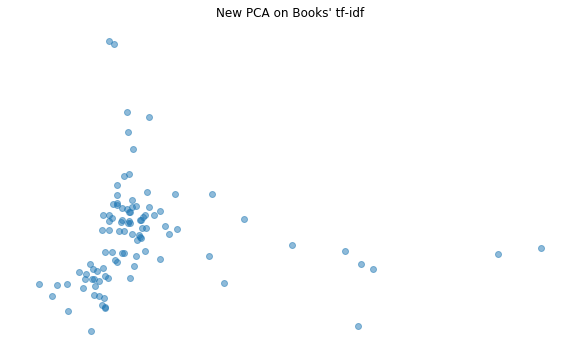

In [103]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(newreduced_data[:, 0], newreduced_data[:, 1], alpha = 0.5)
#for i, booktitle in enumerate(booktitles):
 #   ax.annotate(booktitle, (newreduced_data[i,0], newreduced_data[i,1]))
plt.xticks(())
plt.yticks(())
plt.title('New PCA on Books\' tf-idf')
plt.show()

Clustering algorithm:

In [111]:
numCategories = 3

In [112]:
bookKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
bookKM.fit(newbookgroupTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

This allows us to visualize the top 10 words per cluster:

In [128]:
terms = bookTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = bookKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 any
 eve
 along
 babushka
 become
 already
 across
 arrangement
 battered
 dearest


Cluster 1:
 elves
 due
 bumps
 claimed
 backward
 enters
 businesses
 dragon
 approached
 examine


Cluster 2:
 chopping
 choking
 ceilings
 charlie
 battered
 bumps
 bathtub
 counter
 expecting
 chops




Here we can reduce the tf-idf matrix using PCA in order to make visualization easier.

In [114]:
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in bookKM.labels_]

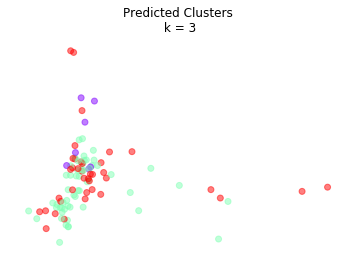

In [115]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(newreduced_data[:, 0], newreduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()